In [1]:
%load_ext autoreload
%autoreload 2
import sys
#sys.path.insert(0, '/gws/nopw/j04/ceh_generic/matbro/ecocrop')
from ecocrop_utils import *
import pandas   as pd
import xarray   as xr
import numpy    as np
import dask     as da
import cftime   as cf
import datetime as dt
import rasterio as rio
import rasterio.plot as rplt
from numba import njit, prange
import matplotlib.pyplot as plt
from IPython.display import Image
import subprocess as subp
import os

Aim is to use the EcoCrop database to produce maps of crop suitability in the UK based on UKCP18 data. One map per year(?) for each species. Regarding the ensemble nature of the driving data we will produce these using ensemble member 01 as this is determined to be the ‘central’ of the ensembles in terms of temperature and precipitation. If time permits, the others could be used as an estimate of uncertainty.

The EcoCrop database contains parameters that determine the range of conditions in which the crop can grow. The ones we will focus on here are temperature, precipitation, killing temperature, habitat zone, latitude and altitude.

The first step is to determine which crops will clearly be unsuitable in the future, regardless of unchecked anphropogenic climate change. We can do this using the habitat zone and latitude. Plants solely able to grow in a tropical environment, or with latitudes that only encompass the tropics, can be removed straight away.

Then we focus on precipitation and temperature. The way to approach temperature is to calculate a forward-rolling total of the number of days within the temperature range, varying the window size up from GMIN until we obtain at least GMIN optimal days. This is the shortest time in which the crop can be grown (GTIME). Then check if the temperature went below the killing temperature within the window, in which case the crop would have failed. So we do a forward-rolling total (so the next x days) of killing temperature days and optimal temperature days, and where a certain day's optimal temperature total exceeds GMIN and the killing-days total is 0, the crop is a success if planted on that day. Then we check that the precip total in the window is within the allowed range for the crop. 

So, for each crop:
- Calculate forward-rolling total of days between TMAXO and TMINO (GTIME), initially with a window size of GMIN, incrementing up to GMAX. Where this is <GMIN, suitability is 0.
- Calculate forward-rolling total of days below KTMP with the same window size: KTMPDAYS for locations where suitability != 0
- KTMPDAYS=0 means successful crop based on T alone, otherwise crop fails, suitability back to 0.
- Calculate forward-total of precip (P) over same window, where suitability != 0, check within range of crop (PMIN and PMAX).
- Calculate suitability score (see below)
- What we have at this stage is a suitability score for a crop for each start day of planting, only considering the shortest possible growing time.
- Repeat for all larger window sizes up to GMAX
- Maximum suitability score from these for each day is final

Then we need to convert this into a suitability score. For temperature this can be based on how soon after GMIN days the crop is ready, for precip this can be based on where within the suitable precip range the actual precip falls. Something like:
$$\left(1-\frac{GTIME - GMIN}{GMAX-GMIN}\right)*100$$
where 
- GMIN is the minimum number of 'growing days' the crop needs 
- GMAX is the maximum
- GTIME is the actual number of 'growing days'
- 'growing days' is defined here as days when the temperature is between TMINO and TMAXO

and
$$\frac{100}{PMINO-PMIN}\left(P-PMIN\right), \:\text{for}\: PMIN<=P<PMINO$$

$$100, \:\text{for}\: PMINO<=P<=PMAXO$$

$$\frac{100}{PMAX-PMAXO}\left(PMAX-P\right), \:\text{for}\: PMAXO<P<=PMAX$$
where
- PMIN is the minimum precip the crop needs
- PMAX is the maximum precip the crop can take
- PMINO is the minimum optimum amount of precip the crop should get
- PMAXO is the maximum optimum amount of precip the crop should get

The precip calc bit looks something like:

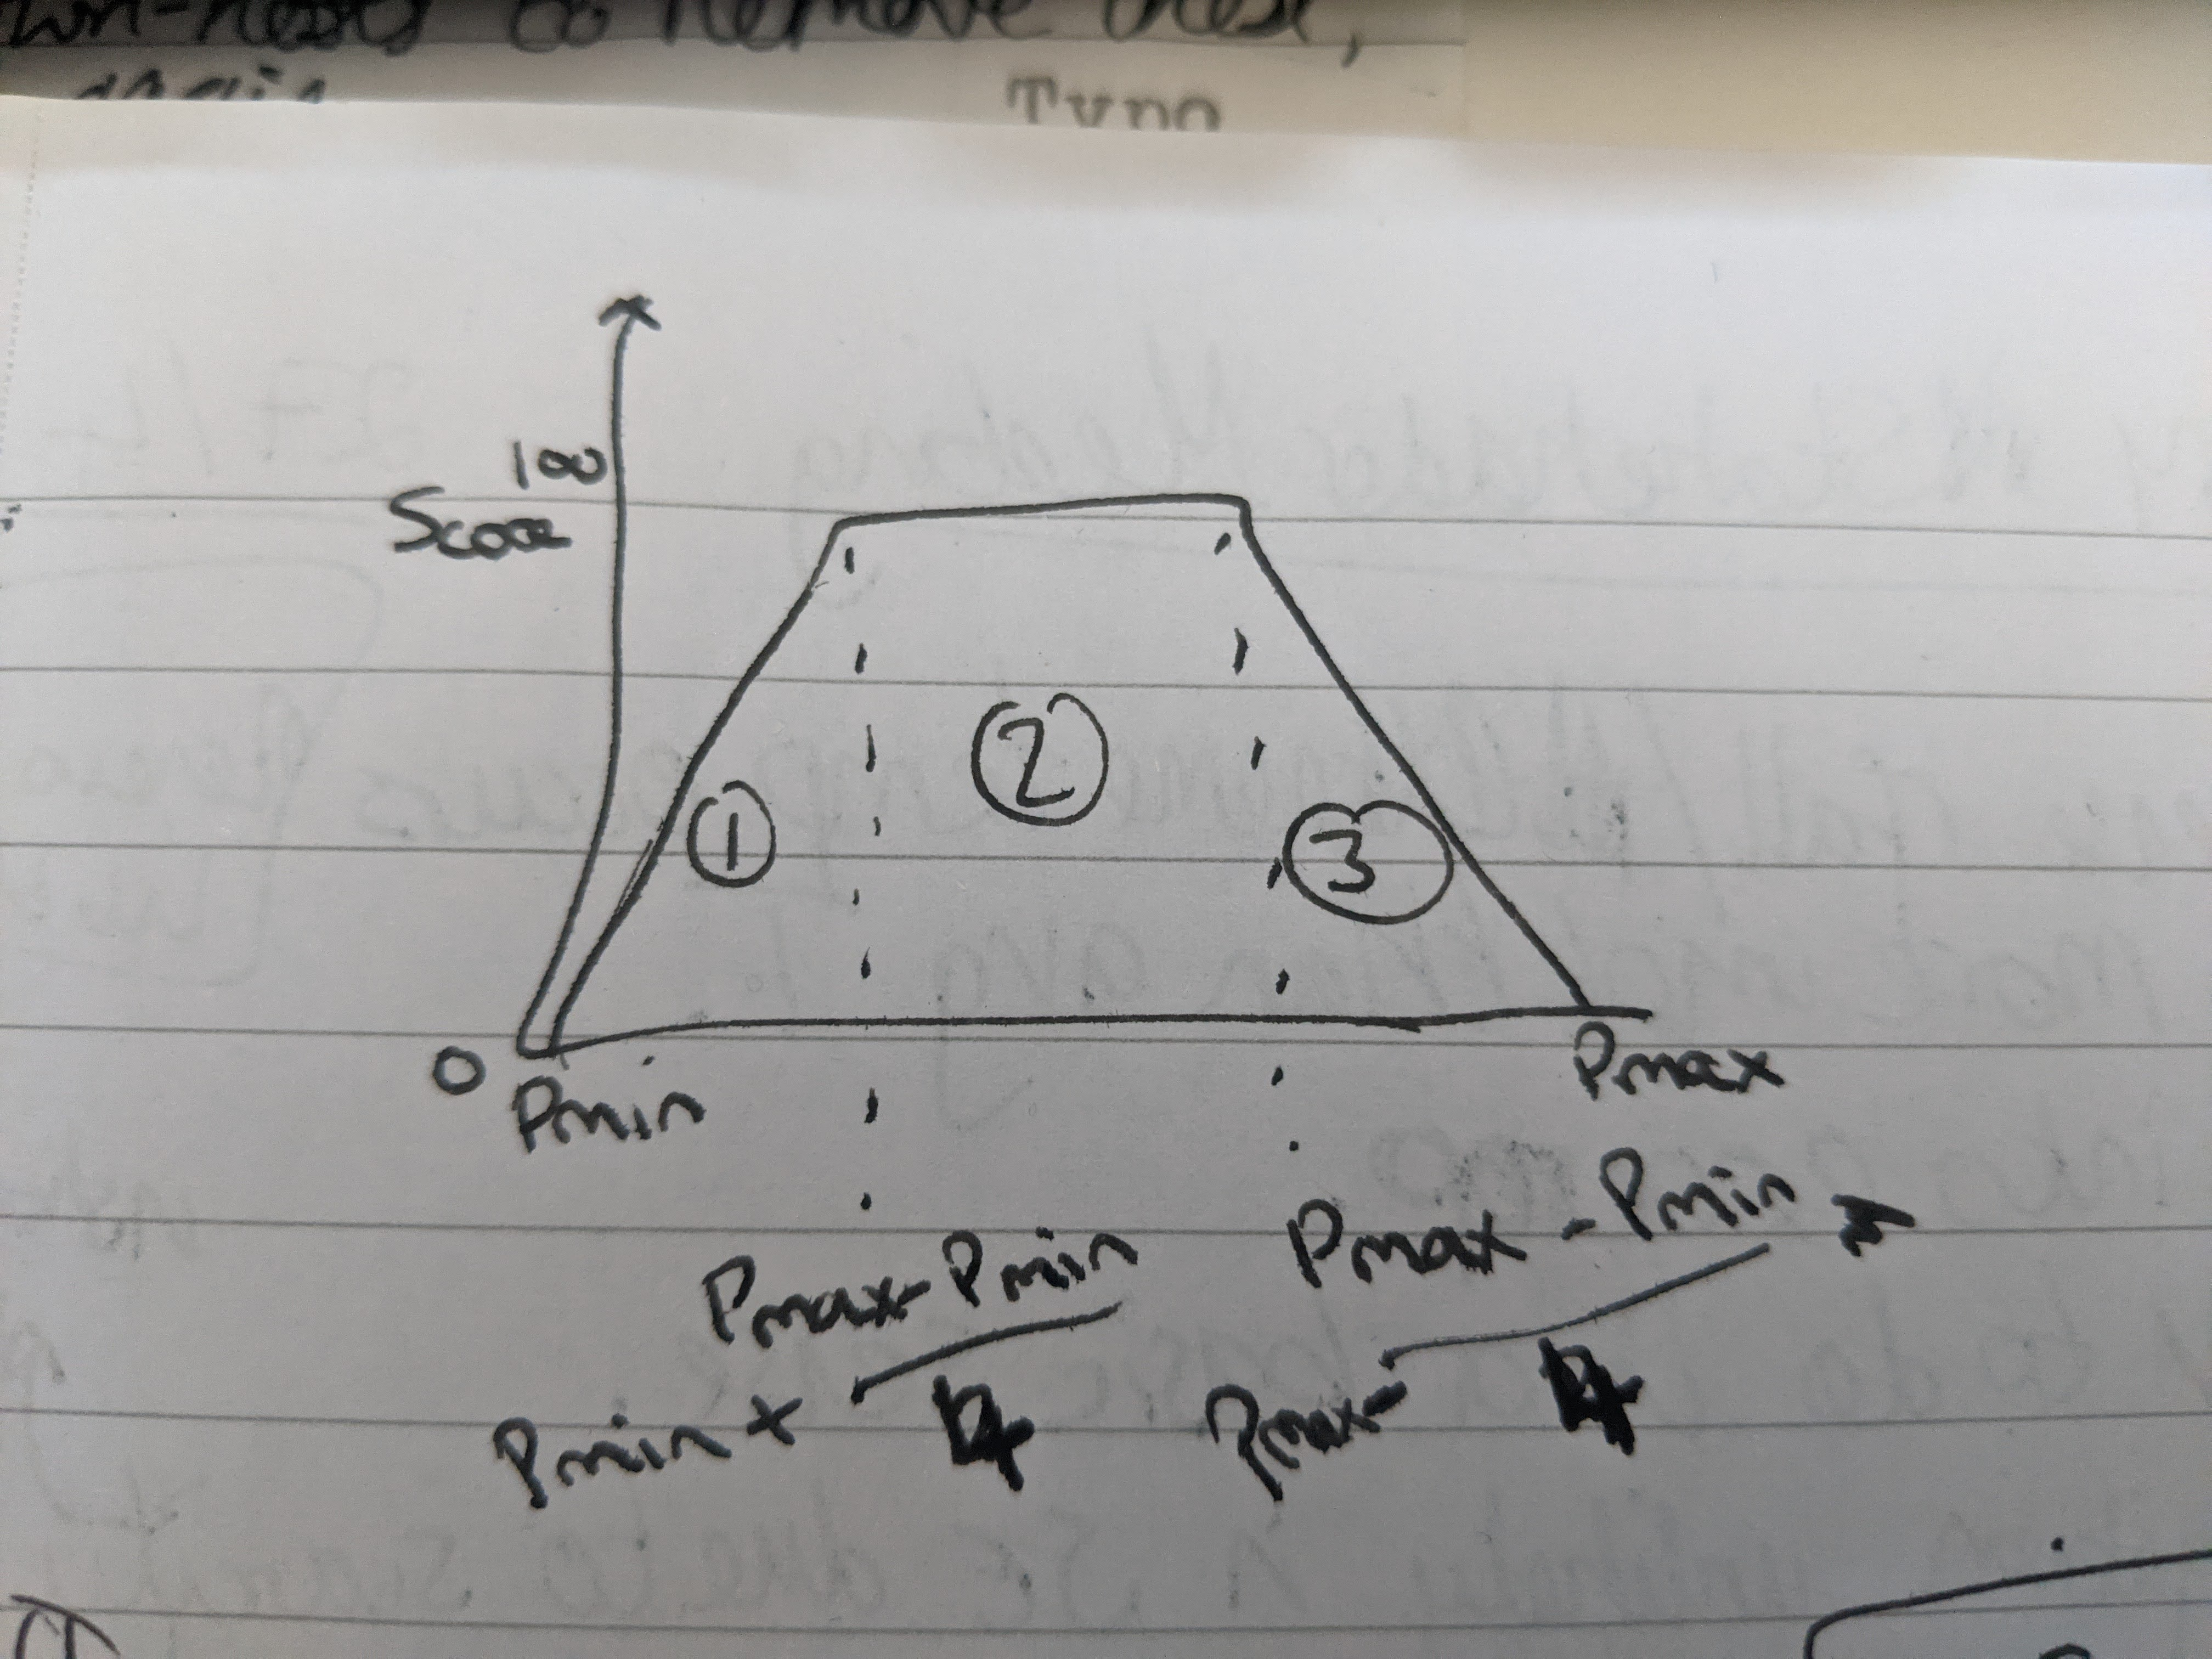

In [9]:
display.Image('Pgraph.jpg')

Could combine both into a bivariate distribution somehow, or just take the average/sum of them.

What makes this tricky is that we have several hundred crops (600). For each of these we need to calculate a suitability score for each day of the 100-year dataset. To do this, we need to calculate a suitability score for all the possible growing-lengths (GTIMEs) between GMIN and GMAX (by summing up the number of days temperature is between a given range). And we have to do this for each grid point in a 1km grid.
This is **A LOT** of number crunching. It is approximately 600x100x365x150x1000x650=2.1E15 (2000 quadrillion) calculations.

We can make some simplifications, like only calculating it for 2020 onwards (rather than 1980), and only calculating for every 10 GTIMEs (i.e. if GMIN was 100 and GMAX is 200, we would calculate for GTIMEs of 100,110,120...200 instead of 100,101,102...200). We could simplify further by not doing the calculation for every day of the dataset, but this makes the coding more complicated as we can no longer use a rolling sum method.
Ultimately, there is no getting around the fact that this is a big calculation. Numpy's vector calculations, and dask's parallelisation help speed things up a bit, and this is the approach I settled with. It is the 'Calculation v2' section below.  

### Initial data processing

#### EcoCrop

In [222]:
ecocropall = pd.read_csv('/gws/nopw/j04/ceh_generic/matbro/ecocrop/EcoCrop_DB.csv', engine='python')

In [223]:
ecocropall = ecocropall.drop(['AUTH', 'FAMNAME', 'SYNO', 'PHOPMN', 'PHOPMX', 'PHMIN', 'PHMAX',
                              'LIOPMN', 'LIOPMX', 'LIMN', 'LIMX', 'DEP', 'DEPR', 
                              'TEXTR', 'FER', 'FERR', 'TOX', 'TOXR', 'SAL', 'SALR', 'DRA', 
                              'DRAR', 'ABITOL', 'ABISUS', 'INTRI', 'PROSY'], axis=1)    

In [224]:
ecocropall

EcoPortCode             ScientificName  \
0             289     Abelmoschus esculentus   
1             290        Abelmoschus manihot   
2             291      Abelmoschus moschatus   
3             295      Acacia auriculiformis   
4             297          Acacia farnesiana   
...           ...                        ...   
2563       400000  Chamaecrista rotundifolia   
2564       400001         Acacia polyacantha   
2565       400002           Prosopis affinis   
2566       400003            Vicia dasycarpa   
2567       400004            Camelina sativa   

                                                COMNAME             LIFO  \
0     abelmoskus, america-neri, bakhua mun, bamia, b...             herb   
1     neka (Simbo), bele (Fiji), pele (Tonga, Tuvalu...            shrub   
2     abelmosk, musk mallow, mushkdan, muskdana, kas...  herb, sub-shrub   
3     Papuan wattle, auri, ear leaf acacia, tuhkehn ...             tree   
4     Ellington curse, klu, cassie, espino blanco, a...             tree   
...                                                 ...              ...   
2563                                     Pasto rastiero              NaN   
2564                                      Black catechu              NaN   
2565                                        Algarobilla              NaN   
2566                                        Hairy vetch              NaN   
2567  camelina, false flax, gold-of-pleasure, gergel...             herb   

                                 HABI                        LISPA  \
0                               erect                       annual   
1                               erect            annual, perennial   
2     prostrate/procumbent/semi-erect  annual, biennial, perennial   
3                               erect                    perennial   
4                               erect                    perennial   
...                               ...                          ...   
2563                              NaN                          NaN   
2564                              NaN                          NaN   
2565                              NaN                          NaN   
2566                              NaN                          NaN   
2567                            erect                       annual   

                       PHYS  \
0               single stem   
1                       NaN   
2     deciduous, multi stem   
3               single stem   
4               single stem   
...                     ...   
2563                    NaN   
2564                    NaN   
2565                    NaN   
2566                    NaN   
2567                    NaN   

                                                    CAT                  PLAT  \
0                                            vegetables  grown on large scale   
1     vegetables, ornamentals/turf, medicinals & aro...  grown on small scale   
2               ornamentals/turf, medicinals & aromatic                   NaN   
3                                           forest/wood  grown on large scale   
4     materials, ornamentals/turf, medicinals & arom...  grown on small scale   
...                                                 ...                   ...   
2563                                                NaN                   NaN   
2564                                                NaN                   NaN   
2565                                                NaN                   NaN   
2566                                                NaN                   NaN   
2567                                                NaN  grown on small scale   

      TOPMN  ...  LATMN  LATMX   ALTMX                           TEXT  KTMPR  \
0      20.0  ...   35.0   40.0  1000.0  heavy, medium, light, organic    NaN   
1      22.0  ...    NaN    NaN  1200.0                medium, organic    NaN   
2      20.0  ...   23.0   29.0   900.0                medium, organic    NaN   
3      24

### Preliminary removals

Remove crops that can only survive in tropical envs

Find all the possible climate zones

In [225]:
allczs = []
for czs in list(ecocropall['CLIZ']):
    czss = str(czs).split(',')
    for cz in czss:
        cz = cz.strip()
        allczs.append(cz)

np.unique(np.asarray(allczs))

array(['boreal (E)', 'desert or arid (Bw)', 'nan', 'polar (F)',
       'steppe or semiarid (Bs)', 'subtropical dry summer (Cs)',
       'subtropical dry winter (Cw)', 'subtropical humid (Cf)',
       'temperate continental (Dc)', 'temperate oceanic (Do)',
       'temperate with dry winters (Dw)',
       'temperate with humid winters (Df)', 'tropical wet & dry (Aw)',
       'tropical wet (Ar)'], dtype='<U33')

In [226]:
# climate zones to exclude
clzexc = ['polar (F)', 'tropical wet & dry (Aw)', 'tropical wet (Ar)']

In [227]:
exclrows = []
for row in range(0,ecocropall.shape[0]):
    clz = ecocropall.iloc[row,:]['CLIZ']
    clz = str(clz).split(',')
    clz = [cl.strip() for cl in clz]
    count = 0
    for exc in clzexc:
        if exc in clz:
            count+=1
        if count==len(clz):
            exclrows.append(row)
            break
        else:
            continue

In [228]:
ecocrop = ecocropall.drop(exclrows)

Remove crops that can only survive at latitudes below 35degN

In [229]:
ecocrop = ecocrop.query('LATMX > 35 or LATMX=="NaN"')

Remove crops that do not have all the required thresholds

In [230]:
ecocrop = ecocrop.reset_index()

exclrows = []
for row in range(0, ecocrop.shape[0]):
    topmn = ecocrop.iloc[row,:]['TOPMN']
    topmx = ecocrop.iloc[row,:]['TOPMX']
    ropmn = ecocrop.iloc[row,:]['ROPMN']
    ropmx = ecocrop.iloc[row,:]['ROPMX']
    rmin  = ecocrop.iloc[row,:]['RMIN']
    rmax  = ecocrop.iloc[row,:]['RMAX']
    if np.isnan(topmn) or np.isnan(topmx) or np.isnan(ropmn) or np.isnan(ropmx) \
    or np.isnan(rmin) or np.isnan(rmax):
        exclrows.append(row)

In [231]:
ecocrop = ecocrop.drop(exclrows)

In [232]:
ecocrop.to_csv('/gws/nopw/j04/ceh_generic/matbro/ecocrop/EcoCrop_DB_firsttrim.csv')

In [233]:
ecocrop = ecocrop.reset_index()
# set any GMIN/GMAXs to 360 if >360, for use with the UKCP18 360day calendar
for row in range(0, ecocrop.shape[0]):
    if ecocrop.loc[row,'GMIN'] > 360:
        ecocrop.loc[row,'GMIN'] = 360
    if ecocrop.loc[row,'GMAX'] > 360:
        ecocrop.loc[row,'GMAX'] = 360

In [234]:
# account for the case when the growing season spans the year boundary.
# assume erroneous data and drop rows
ecocrop = ecocrop.drop(['level_0'], axis=1)
ecocrop = ecocrop.reset_index()
exclrows = []
for row in range(0, ecocrop.shape[0]):
    if ecocrop.loc[row,'GMAX'] < ecocrop.loc[row,'GMIN']:
        print(ecocrop.loc[row,'GMAX'], ecocrop.loc[row,'GMIN'])
        exclrows.append(row)
ecocrop = ecocrop.drop(exclrows)

0.0 90.0


In [235]:
# account for 0s in the GMIN/GMAXs. Assume no data and drop rows.
ecocrop = ecocrop.drop(['level_0'], axis=1)
ecocrop = ecocrop.reset_index()
exclrows = []
for row in range(0, ecocrop.shape[0]):
    if ecocrop.loc[row,'GMIN'] == 0 or ecocrop.loc[row,'GMAX'] == 0:
        print(ecocrop.loc[row,'GMIN'], ecocrop.loc[row,'GMAX'])
        exclrows.append(row)
ecocrop = ecocrop.drop(exclrows)

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


In [236]:
ecocrop.to_csv('/gws/nopw/j04/ceh_generic/matbro/ecocrop/EcoCrop_DB_secondtrim.csv')

The different possibilities for the lifespans

In [31]:
allczs = []
for czs in list(ecocropall['LISPA']):
    czss = str(czs).split(',')
    for cz in czss:
        cz = cz.strip()
        allczs.append(cz)

np.unique(np.asarray(allczs))

array(['annual', 'biennial', 'nan', 'perennial'], dtype='<U9')

The different KTMP possibilities

In [2]:
ecocroploc = '/gws/nopw/j04/ceh_generic/matbro/ecocrop/EcoCrop_DB_secondtrim.csv'
ecocropall = pd.read_csv(ecocroploc, engine='python')

In [3]:
allktmps = []
for ktmp in list(ecocropall['KTMP']):
    ktmps = str(ktmp).split(',')
    for kt in ktmps:
        kt = kt.strip()
        allktmps.append(kt)

print(np.unique(np.asarray(allktmps)))
print(len(np.unique(np.asarray(allktmps))))

['-1.0' '-2.0' '-20.0' '-3.0' '-4.0' '-5.0' '-6.0' '-8.0' '-9.0' '0.0'
 '1.0' '4.0' '5.0' '9.0' 'nan']
15


The different TOPMAX possibilities

In [4]:
alltmaxs = []
for tmax in list(ecocropall['TOPMX']):
    tmaxs = str(tmax).split(',')
    for tm in tmaxs:
        tm = tm.strip()
        alltmaxs.append(tm)

print(np.unique(np.asarray(alltmaxs)))
print(len(np.unique(np.asarray(alltmaxs))))

['14.0' '15.0' '16.0' '17.0' '18.0' '19.0' '20.0' '21.0' '22.0' '23.0'
 '24.0' '25.0' '26.0' '27.0' '28.0' '29.0' '30.0' '31.0' '32.0' '33.0'
 '34.0' '35.0' '36.0' '37.0' '38.0' '40.0' '42.0' '45.0']
28


The different TOPMIN possibilities

In [5]:
alltmins = []
for tmin in list(ecocropall['TOPMN']):
    tmins = str(tmin).split(',')
    for tm in tmins:
        tm = tm.strip()
        alltmins.append(tm)

print(np.unique(np.asarray(alltmins)))
print(len(np.unique(np.asarray(alltmins))))

['10.0' '11.0' '12.0' '13.0' '14.0' '15.0' '16.0' '17.0' '18.0' '19.0'
 '20.0' '21.0' '22.0' '23.0' '24.0' '25.0' '26.0' '27.0' '28.0' '30.0'
 '31.0' '5.0' '7.0' '8.0' '9.0']
25


The different possible TOPMAX and TOPMIN combinations

In [18]:
allTOPS = []
for row in range(0, ecocropall.shape[0]):
    TOPMX = str(ecocropall.iloc[row,:]['TOPMX'])
    TOPMN = str(ecocropall.iloc[row,:]['TOPMN'])    
    if len(TOPMN)==3:
        TOPMN = '0'+TOPMN
    TOPMX = TOPMX.split('.')[0]
    TOPMN = TOPMN.split('.')[0]
    if int(TOPMX)<33:
        TOPS = TOPMX+TOPMN
        allTOPS.append(TOPS)
allTOPS = np.asarray(allTOPS)
TOPSunq = np.unique(allTOPS)
with open('/work/scratch-pw/mattjbr/ecocrop_lotus/TOPS.txt', 'w') as outfile:
    for TOP in TOPSunq:
        line = TOP[:2] + ',' + TOP[2:]
        print(line)
        outfile.writelines(line+'\n')
        
print(len(TOPSunq))
#print(np.unique(np.asarray(alltmins)))
#print(len(np.unique(np.asarray(alltmins))))

14,14
15,08
15,10
16,08
16,09
16,10
17,10
17,11
17,12
18,09
18,10
18,11
18,12
18,14
18,15
19,05
19,07
19,13
19,14
19,15
20,07
20,08
20,09
20,10
20,11
20,12
20,13
20,14
20,15
20,16
21,07
21,10
21,12
21,15
21,17
22,08
22,09
22,10
22,11
22,12
22,13
22,14
22,15
22,16
22,18
23,13
23,14
23,15
23,17
23,18
24,10
24,12
24,14
24,15
24,16
24,17
24,18
25,08
25,10
25,12
25,13
25,14
25,15
25,16
25,17
25,18
25,19
25,20
26,10
26,12
26,14
26,15
26,16
26,17
26,18
26,20
26,21
26,22
27,08
27,12
27,13
27,14
27,15
27,16
27,17
27,18
27,19
27,21
27,22
27,24
28,09
28,12
28,13
28,14
28,15
28,16
28,17
28,18
28,19
28,20
28,21
28,22
28,23
29,13
29,15
29,18
29,22
30,10
30,12
30,13
30,14
30,15
30,16
30,17
30,18
30,20
30,21
30,22
30,23
30,24
30,25
30,26
31,20
31,21
31,22
31,23
32,12
32,14
32,15
32,16
32,17
32,18
32,20
32,22
32,23
32,24
32,25
32,26
138


The KMAX possibilities:

In [10]:
alltmins = []
for tmin in list(ecocropall['TMAX']):
    tmins = str(tmin).split(',')
    for tm in tmins:
        tm = tm.strip()
        alltmins.append(tm)

print(np.unique(np.asarray(alltmins)))
print(len(np.unique(np.asarray(alltmins))))

['20.0' '21.0' '22.0' '23.0' '24.0' '25.0' '26.0' '27.0' '28.0' '29.0'
 '30.0' '31.0' '32.0' '33.0' '34.0' '35.0' '36.0' '37.0' '38.0' '39.0'
 '40.0' '41.0' '42.0' '43.0' '45.0' '47.0' '49.0' '50.0' '52.0' '55.0']
30


The different GTIME possibilites

In [17]:
allgtimes = []
for gmin, gmax in zip(list(ecocropall['GMIN']), list(ecocropall['GMAX'])):
    print(gmin, gmax)

50.0 180.0
60.0 240.0
150.0 240.0
120.0 150.0
85.0 175.0
60.0 160.0
90.0 120.0
30.0 300.0
40.0 150.0
80.0 160.0
210.0 270.0
110.0 270.0
300.0 360.0
160.0 240.0
150.0 180.0
90.0 300.0
90.0 120.0
40.0 90.0
50.0 100.0
85.0 175.0
60.0 120.0
60.0 200.0
100.0 130.0
80.0 120.0
70.0 100.0
240.0 360.0
80.0 300.0
60.0 180.0
120.0 180.0
180.0 360.0
120.0 180.0
70.0 85.0
90.0 330.0
140.0 330.0
60.0 360.0
180.0 360.0
180.0 360.0
35.0 140.0
70.0 100.0
40.0 180.0
80.0 140.0
80.0 140.0
150.0 180.0
270.0 330.0
40.0 150.0
210.0 330.0
220.0 300.0
125.0 300.0
45.0 180.0
150.0 210.0
180.0 360.0
180.0 360.0
150.0 240.0
120.0 270.0
120.0 300.0
60.0 100.0
30.0 110.0
75.0 180.0
150.0 200.0
150.0 300.0
70.0 200.0
80.0 150.0
90.0 180.0
100.0 240.0
90.0 240.0
90.0 210.0
80.0 170.0
35.0 85.0
100.0 360.0
90.0 270.0
70.0 180.0
120.0 180.0
40.0 150.0
360.0 360.0
180.0 320.0
180.0 320.0
100.0 210.0
180.0 330.0
70.0 150.0
80.0 270.0
360.0 360.0
80.0 180.0
90.0 180.0
80.0 150.0
120.0 210.0
60.0 360.0
50.0 270.0
360.0 36

### Calculations v1

Array needed to store all the scores for all the possible growing periods will be larger than memory allows. So have to save each to disk, then read them all in using dask to calculate the maximum.

In [35]:
comname = '_'.join(COMNAME.split(' '))

outdir = 'outputs'
if not os.path.exists(outdir):
    os.makedirs(outdir)

for gtime in range(int(GMIN), int(GMAX+1)):
    print('Calculating suitability for ' + comname + \
          ' for a growing season of length ' + str(gtime) + \
          ' out of a maximum of ' + str(int(GMAX)))
    # calculate where GMIN days of T in optimal range is satisfied with growing window of gtime
    toptdays_crop = topt_crop[::-1,:,:].rolling(time=gtime).sum()[::-1,:,:]
    suit_crop = xr.where(toptdays_crop >= GMIN, 1, 0)

    # calculate whether any of the suitable days/locations identified above will have
    # frost/killing temp in their growing window, and set suitability to 0 if so
    ktmp_days = ktmp_crop[::-1,:,:].rolling(time=gtime).sum()[::-1,:,:]
    suit_crop2 = xr.where(ktmp_days > 0, 0, suit_crop)

    # calculate total precipitation in the growing window and mask out any of the 
    # suitable locations/days identified above if not within range for crop
    precip_crop = prec[::-1,:,:].rolling(time=gtime).sum()[::-1,:,:]
    precip_suit = xr.where(precip_crop > PMIN, suit_crop2, 0)
    precip_suit = xr.where(precip_crop < PMAX, precip_suit, 0)
    precip_suit_total = xr.where(precip_suit > 0, precip_crop, 0)

    # calculate the suitability scores for temp and precip (see above)
    tempscore = xr.where(precip_suit > 0, score_temp(gtime, GMIN, GMAX), 0)
    precscore = score_prec(precip_suit_total.where(precip_suit_total>0), PMIN, PMAX, POPMIN, POPMAX)

    # calculate final suitability score (take minimum of temp and precip scores)
    final_score_crop = xr.where(precscore < tempscore, precscore, tempscore)

    final_score_crop.name = 'suitability_score'
    final_score_crop.encoding['zlib'] = True
    final_score_crop.encoding['complevel'] = 1
    final_score_crop.encoding['shuffle'] = False
    final_score_crop.encoding['contiguous'] = False
    final_score_crop.encoding['dtype'] = np.dtype('uint16')
    encoding = {}
    encoding['suitability_score'] = final_score_crop.encoding
    filepath = os.path.join(outdir, 'final_score_crop_'+comname+'_glen_'+str(gtime)+'.nc')
    final_score_crop.to_netcdf(filepath, encoding=encoding)

    del toptdays_crop
    del suit_crop
    del ktmp_days
    del suit_crop2
    del precip_crop
    del precip_suit
    del precip_suit_total
    del tempscore
    del precscore
    del final_score_crop

Calculating suitability for Onions_(bulb) for a growing season of length 85 out of a maximum of 175


NameError: name 'prec' is not defined

In [80]:
test = xr.open_mfdataset('outputs/*.nc', combine='by_coords', preprocess=add_glen_dim, parallel=True)
testmax = test.max(dim='glen')

with ProgressBar():
    testmax.encoding['zlib'] = True
    testmax.encoding['complevel'] = 1
    testmax.encoding['shuffle'] = False
    testmax.encoding['contiguous'] = False
    testmax.encoding['dtype'] = np.dtype('uint16')
    encoding={}
    encoding['suitability_score'] = testmax.encoding
    testmax.to_netcdf('outputs/final_max_score_crop_Onions_(bulb).nc', encoding=encoding)

In [119]:
testmax = xr.load_dataset('outputs/final_max_score_crop_Onions_(bulb).nc')

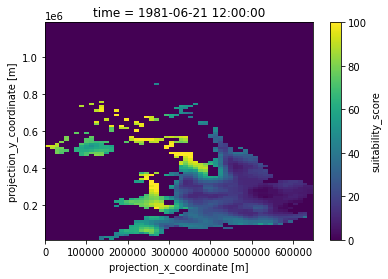

In [127]:
testmax['suitability_score'][200,:,:].plot()

This works.

### Calculations v2

Next step is to adapt it for use with the 1km met data (instead of 12km). Due to the much larger amount of memory used this will need to be run on the JASMIN LOTUS HPC high-mem queue. Will leave an example here.

Precalc stage 1: Calculate the cumulative sums of
- a) Ndays within the optimal T range
- b) Ndays below KTMP
- c) Ndays above KMAX?
- d) Precip

across the entire length of the dataset

Precalcs stage 2 - Use these cumulative sums to calculate the number of days in 
- a) the optimum temperature range, 
- b) the number of days below the killing temperature 
- c) the number of days above the heat killing temperature?
- d) the cumulative precip 

within a given 'growing period' length (GTIME). 

Step 3 - Calculate the suitability score from the files we've generated

Data paths and thresholds

In [6]:
# year to test out script on
year = 2020

# 1 to load metdata, 0 otherwise
loaddata = 0

ecocroploc = '/gws/nopw/j04/ceh_generic/matbro/ecocrop/EcoCrop_DB_secondtrim.csv'
taspath = '/work/scratch-pw/mattjbr/ecocrop/metdata/ukcp18_rcp85_land-rcm_uk_1km_01_v20190731_tas_bias_corrected_' + str(year) + '.nc'
prepath = '/work/scratch-pw/mattjbr/ecocrop/metdata/ukcp18_rcp85_land-rcm_uk_1km_01_v20190731_pr_bias_corrected_' + str(year) + '.nc'
tmnpath = '/work/scratch-pw/mattjbr/ecocrop/metdata/ukcp18_rcp85_land-rcm_uk_1km_01_v20190731_tasmin_bias_corrected_' + str(year) + '.nc'
tmxpath = '/work/scratch-pw/mattjbr/ecocrop/metdata/ukcp18_rcp85_land-rcm_uk_1km_01_v20190731_tasmax_bias_corrected_' + str(year) + '.nc'
tasvname = 'tas'
prevname = 'pr'
tmnvname = 'tasmin'
tmxvname = 'tasmax'
#predir = '/gws/nopw/j04/ceh_generic/matbro/ecocrop/precalcs/precalcs'
savedir = '/gws/nopw/j04/ceh_generic/matbro/ecocrop/scores_test'
lcmloc = '/gws/nopw/j04/ceh_generic/matbro/ecocrop/LCM15_Arable_Mask.tif'
bgsloc = '/gws/nopw/j04/ceh_generic/matbro/ecocrop/BGS_soildata/masks'
plotdir = '/gws/nopw/j04/ceh_generic/matbro/ecocrop/plots'
cropname = 'wheat'

ecocropall = pd.read_csv(ecocroploc, engine='python')
ecocrop = ecocropall.drop(['level_0'], axis=1)
testcrop = ecocrop.iloc[393,:] # 19 onions, #117 wheat, #147 chickpea, #66 sweet potato
TOPMIN = testcrop['TOPMN'] + 273.15 # C-->K
TOPMAX = testcrop['TOPMX'] + 273.15 # C-->K
PMIN = testcrop['RMIN']/86400. # mm-->kg/m^2/s
PMAX = testcrop['RMAX']/86400. # mm-->kg/m^2/s
POPMIN = testcrop['ROPMN']/86400. # mm-->kg/m^2/s
POPMAX = testcrop['ROPMX']/86400. # mm-->kg/m^2/s
KTMP = testcrop['KTMPR'] + 273.15 # C-->K
KMAX = testcrop['TMAX'] + 273.15  # C-->K
GMIN = int(testcrop['GMIN'])
GMAX = int(testcrop['GMAX'])
SOIL = testcrop['TEXT']
COMNAME = testcrop['COMNAME']
COMNAME = '_'.join(COMNAME.split(',')[0].split(' '))
if '(' in COMNAME:
    COMNAME = ''.join(COMNAME.split('('))
    COMNAME = ''.join(COMNAME.split(')'))
if "'" in COMNAME:
    COMNAME = ''.join(COMNAME.split("'"))
cropname=COMNAME

# assume killing temp of -1 if not specified
if np.isnan(KTMP):
    KTMP=-1

print('TOPMN: ' + str(testcrop['TOPMN']))
print('TOPMX: ' + str(testcrop['TOPMX']))
print('KTMP: ' + str(testcrop['KTMPR']))
print('KMAX: ' + str(testcrop['TMAX']))
print('GMIN: ' + str(testcrop['GMIN']))
print('GMAX: ' + str(testcrop['GMAX']))
print('PMIN: ' + str(testcrop['RMIN']))
print('PMAX: ' + str(testcrop['RMAX']))
print('POPMIN: ' + str(testcrop['ROPMN']))
print('POPMAX: ' + str(testcrop['ROPMX']))
print('SOIL: ' + str(SOIL))
print('COMNAME: ' + COMNAME)

########## STAGE 1 & 2 ############
#
# For the KTMP, KMAX and PREC calcs, we can use the pre-calculated
# cumulative sums that are saved on disk
#
# For the TEMP calculation we have to read in the metdata from scratch
# as there are too many permutations to pre-calc it beforehand

if not os.path.exists(savedir):
    os.makedirs(savedir)
if not os.path.exists(plotdir):
    os.makedirs(plotdir)

# open datafiles
if loaddata == 1:
    print('Reading in met data')
    tas = xr.open_dataset(taspath).astype('float16')[tasvname]
    tmn = xr.open_dataset(tmnpath).astype('float16')[tmnvname]
    tmx = xr.open_dataset(tmxpath).astype('float16')[tmxvname]
    pre = xr.open_dataset(prepath)[prevname]

print('Calculating where/when temperature suitable')
topt_crop = xr.where(xr.ufuncs.logical_and(tas < TOPMAX, tas > TOPMIN), 1, 0).astype('uint16').values
ktmp_crop = xr.where(tmn < KTMP, 1, 0).astype('uint16').values
kmax_crop = xr.where(tmx > KMAX, 1, 0).astype('uint16').values

gstart = np.int16(np.ceil(GMIN/10)*10)
gend   = np.int16(np.ceil(GMAX/10)*10)
allgtimes = list(np.arange(gstart, gend, 10, dtype='int16'))

counter=1
GMIN = np.uint16(GMIN)
GMAX = np.uint16(GMAX)
for gtime in allgtimes:
    print('Calculating suitability for ' + COMNAME + \
          ' for a growing season of length ' + str(gtime) + \
          ' out of a maximum of ' + str(int(GMAX)))

    # calculate ndays of T in optimal range within gtime
    tcoords_tas = tas['time'][:-gtime+1]
    ycoords_tas = tas['y']
    xcoords_tas = tas['x']
    toptdays = frs3D(topt_crop, gtime, 'uint16')
    toptdays = xr.DataArray(toptdays, coords=[tcoords_tas, ycoords_tas, xcoords_tas])
    toptdays.name = 'TOPT_days'

    # calculate whether any of the suitable days/locations identified above will have
    # frost/killing temp within gtime
    tcoords_tmn = tmn['time'][:-gtime+1]
    ycoords_tmn = tmn['y']
    xcoords_tmn = tmn['x']
    ktmp_days = frs3D(ktmp_crop, gtime, 'uint16')
    ktmp_days = xr.DataArray(ktmp_days, coords=[tcoords_tmn, ycoords_tmn, xcoords_tmn])
    ktmp_days.name = 'KTMP_days'

    # calculate whether any of the suitable days/locations identified above will have
    # heat killing temp within gtime
    tcoords_tmx = tmx['time'][:-gtime+1]
    ycoords_tmx = tmx['y']
    xcoords_tmx = tmx['x']
    kmax_days = frs3D(kmax_crop, gtime, 'uint16')
    kmax_days = xr.DataArray(kmax_days, coords=[tcoords_tmx, ycoords_tmx, xcoords_tmx])
    kmax_days.name = 'KMAX_days'

    # calculate total precipitation in gtime
    tcoords_pre = pre['time'][:-gtime+1]
    ycoords_pre = pre['y']
    xcoords_pre = pre['x']
    pre2 = pre.values
    precip_crop = frs3D(pre2, gtime, 'float32')
    precip_crop = xr.DataArray(precip_crop, coords=[tcoords_pre, ycoords_pre, xcoords_pre])
    precip_crop.name = 'precip_total'

    ########### STAGE 3 #############


    print('Calculating where T suitable within GTIME')
    suit_crop = xr.where(toptdays >= GMIN, 1, 0).astype('uint8')

    # if they are different lengths it will likely be because the end of the data is missing
    # (due to a minor bug in the frs3D functions), so need to account for this
    #print('Calculating KMAX')
    #kmaxfname = 'KMAX_' + str(int(testcrop['TMAX'])) + \
    #            '_gtime_' + str(int(gtime)) + 'v2.nc'
    #kmaxpath = os.path.join(predir, kmaxfname)
    #kmax_days = xr.open_dataset(kmaxpath)['KMAXdays'].astype('uint16')
    #if len(kmax_days['time']) > len(suit_crop['time']):
    #    kmax_days = kmax_days.sel(time=slice(suit_crop['time'][0], suit_crop['time'][-1]))
    #elif len(kmax_days['time']) < len(suit_crop['time']):
    #    suit_crop = suit_crop.sel(time=slice(kmax_days['time'][0], kmax_days['time'][-1]))
    #suit_crop2 = xr.where(kmax_days > np.uint8(0), suit_crop - np.uint8(kmax_days), suit_crop)

    print('Calculating KTMP')
    #ktmpfname = 'KTMP_' + str(int(testcrop['KTMPR'])) + \
    #            '_gtime_' + str(int(gtime)) + 'v2.nc'
    #ktmppath = os.path.join(predir, ktmpfname)
    #ktmp_days = xr.open_dataset(ktmppath)['KTMPdays'].astype('uint16')
    #if len(ktmp_days['time']) > len(suit_crop2['time']):
    #    ktmp_days = ktmp_days.sel(time=slice(suit_crop2['time'][0], suit_crop2['time'][-1]))
    #elif len(ktmp_days['time']) < len(suit_crop2['time']):
    #    suit_crop2 = suit_crop2.sel(time=slice(ktmp_days['time'][0], ktmp_days['time'][-1]))
    suit_crop2 = xr.where(ktmp_days > np.uint8(0), np.uint8(0), suit_crop)

    print('Calculating T suitability score and KMAX days penalty')
    tscore = score_temp(gtime, GMIN, GMAX)
    tempscore1 = xr.where(suit_crop2 > np.uint8(0), tscore, np.uint8(0)).astype('int8')
    kmax_days = xr.where(suit_crop2 > np.uint8(0), kmax_days, np.uint(0))
    tempscore = tempscore1 - np.int8(kmax_days)
    tempscore = xr.where(tempscore < 0, 0, tempscore).astype('uint8')

    #precfname = 'PREC_' + \
    #            'gtime_' + str(int(gtime)) + 'v2.nc'
    #precpath = os.path.join(predir, precfname)
    #print('Loading prec file')
    #precip_crop = xr.open_dataset(precpath)['PRECtotal'].astype('float16')
    print('Calculating precip suitability score')
    precscore = score_prec(precip_crop, PMIN, PMAX, POPMIN, POPMAX)

    print('Merging T & P suitability scores')
    if counter==1:
        final_score_crop_old = xr.where(precscore < tempscore, precscore, tempscore)
        tempscore_old = tempscore
        precscore_old = precscore
        #print(final_score_crop_old.dtype)
        #print(final_score_crop_old.shape)
    else:
        final_score_crop = xr.where(precscore < tempscore, precscore, tempscore)
        print(final_score_crop.dtype)
        if len(final_score_crop_old['time']) > len(final_score_crop['time']):
            final_score_crop_old = final_score_crop_old.sel(time=slice(final_score_crop['time'][0], final_score_crop['time'][-1]))
        if len(tempscore_old['time']) > len(tempscore['time']):
            tempscore_old = tempscore_old.sel(time=slice(tempscore['time'][0], tempscore['time'][-1]))
        if len(precscore_old['time']) > len(precscore['time']):
            precscore_old = precscore_old.sel(time=slice(precscore['time'][0], precscore['time'][-1]))
        #print(final_score_crop_old.dtype)
        #print(final_score_crop.shape)
        final_score_crop = xr.where(final_score_crop > final_score_crop_old, final_score_crop, final_score_crop_old)
        tempscore = xr.where(tempscore > tempscore_old, tempscore, tempscore_old)#.astype('uint8')
        precscore = xr.where(precscore > precscore_old, precscore, precscore_old)#.astype('uint8')
        #print(final_score_crop.dtype)

        final_score_crop_old = final_score_crop
        tempscore_old = tempscore
        precscore_old = precscore

        del suit_crop
        del suit_crop2
    counter+=1

final_score_crop.name = 'crop_suitability_score'
final_score_crop.encoding['zlib'] = True
final_score_crop.encoding['complevel'] = 1
final_score_crop.encoding['shuffle'] = False
final_score_crop.encoding['contiguous'] = False
final_score_crop.encoding['dtype'] = np.dtype('uint8')
encoding = {}
encoding['crop_suitability_score'] = final_score_crop.encoding
final_score_crop.to_netcdf(os.path.join(savedir, cropname + '.nc'), encoding=encoding)

tempscore.name = 'temperature_suitability_score'
tempscore.encoding['zlib'] = True
tempscore.encoding['complevel'] = 1
tempscore.encoding['shuffle'] = False
tempscore.encoding['contiguous'] = False
tempscore.encoding['dtype'] = np.dtype('uint8')
encoding = {}
encoding['temperature_suitability_score'] = tempscore.encoding
tempscore.to_netcdf(os.path.join(savedir, cropname + '_temp.nc'), encoding=encoding)

precscore.name = 'precip_suitability_score'
precscore.encoding['zlib'] = True
precscore.encoding['complevel'] = 1
precscore.encoding['shuffle'] = False
precscore.encoding['contiguous'] = False
precscore.encoding['dtype'] = np.dtype('uint8')
encoding = {}
encoding['precip_suitability_score'] = precscore.encoding
precscore.to_netcdf(os.path.join(savedir, cropname + '_prec.nc'), encoding=encoding)

TOPMN: 15.0
TOPMX: 19.0
KTMP: nan
KMAX: 35.0
GMIN: 150.0
GMAX: 210.0
PMIN: 300.0
PMAX: 1300.0
POPMIN: 400.0
POPMAX: 700.0
SOIL: medium
COMNAME: hop


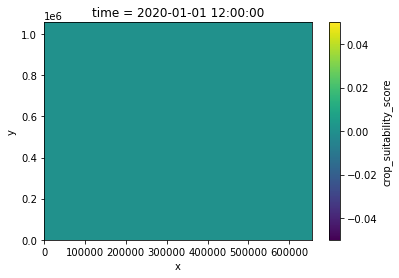

In [86]:
final_score_crop[0,:,:].plot()

In [87]:
cropname = 'wheat'

In [88]:
final_score_crop = xr.load_dataset('scores/' + cropname + '.nc')['crop_suitability_score']
tempscore = xr.load_dataset('scores/' + cropname + '_temp.nc')['temperature_suitability_score']
precscore = xr.load_dataset('scores/' + cropname + '_prec.nc')['precip_suitability_score']

In [89]:
allscore_decadal_changes, tempscore_decadal_changes, precscore_decadal_changes = \
calc_decadal_changes(final_score_crop, tempscore, precscore, str(SOIL), 'LCM15_Arable_Mask.tif', 'BGS_soildata/masks', cropname, 'scores_test')

Calculating yearly score
Doing masking
Doing masking for medium soil group
Doing masking for medium soil group
Doing masking for medium soil group
Calculating decadal score


In [90]:
allscore_years = xr.load_dataset('scores_test/' + cropname + '_years.nc')['crop_suitability_score']
tempscore_years = xr.load_dataset('scores_test/' + cropname + '_tempscore_years.nc')['temperature_suitability_score']
precscore_years = xr.load_dataset('scores_test/' + cropname + '_precscore_years.nc')['precip_suitability_score']

In [111]:
allscore_decades = xr.load_dataset('scores_test/' + cropname + '_decades.nc')['crop_suitability_score']
tempscore_decades = xr.load_dataset('scores_test/' + cropname + '_tempscore_decades.nc')['temperature_suitability_score']
precscore_decades = xr.load_dataset('scores_test/' + cropname + '_precscore_decades.nc')['precip_suitability_score']

In [113]:
print('PMIN: ' + str(testcrop['RMIN']))
print('PMAX: ' + str(testcrop['RMAX']))
print('POPMIN: ' + str(testcrop['ROPMN']))
print('POPMAX: ' + str(testcrop['ROPMX']))


PMIN: 300.0
PMAX: 1600.0
POPMIN: 750.0
POPMAX: 900.0


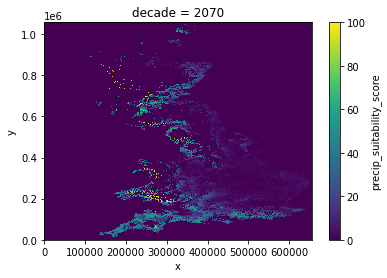

In [118]:
precscore_decades[5,:,:].plot()

Plot decadal change

51.0
-35.0


/gws/nopw/j04/ceh_generic/matbro/ecocrop/ecocrop_utils.py:158: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  fig, axs = plt.subplots(1,3, subplot_kw={'projection': cp.crs.OSGB()})


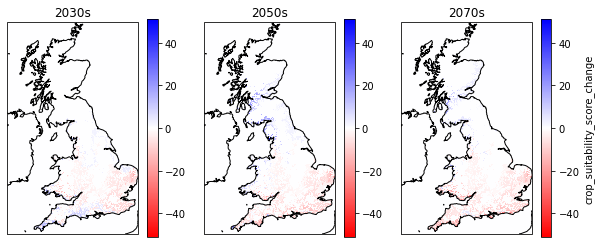

In [174]:
plot_decadal_changes(allscore_decadal_changes, save='plots_test/' + cropname + '_decadal_changes.png')

95.0
-76.0


/gws/nopw/j04/ceh_generic/matbro/ecocrop/ecocrop_utils.py:158: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  axs[0].coastlines(resolution='10m')
/home/users/mattjbr/anaconda3/envs/ecocrop/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


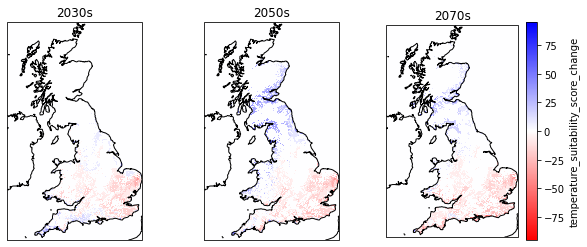

In [102]:
plot_decadal_changes(tempscore_decadal_changes, save='plots_test/' + cropname + '_decadal_changes_temp.png')

8.0
-100.0


/gws/nopw/j04/ceh_generic/matbro/ecocrop/ecocrop_utils.py:158: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  axs[0].coastlines(resolution='10m')
/home/users/mattjbr/anaconda3/envs/ecocrop/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


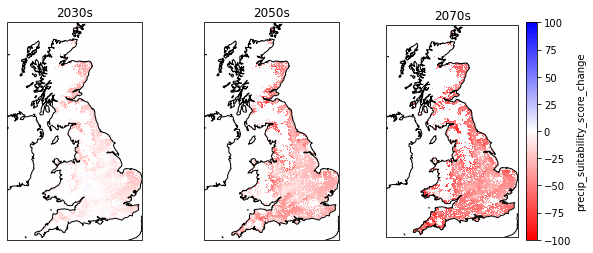

In [103]:
plot_decadal_changes(precscore_decadal_changes, save='plots_test/' + cropname + '_decadal_changes_prec.png')

--------------

In [92]:
for year in range(2020, 2080):
    print('Plotting year ' + str(year))
    final_score_crop_years.sel(year=year).plot.pcolormesh(vmin=0, vmax=100)
    plt.savefig('plots/wheat_year_'+str(year)+'.png', dpi=600)
    plt.close()
    tempscore_years.sel(year=year).plot.pcolormesh(vmin=0, vmax=100)
    plt.savefig('plots/wheat_tempscore_year_'+str(year)+'.png', dpi=600)
    plt.close()
    precscore_years.sel(year=year).plot.pcolormesh(vmin=0, vmax=100)
    plt.savefig('plots/wheat_precipscore_year_'+str(year)+'.png', dpi=600)
    plt.close()

Plotting year 2020
Plotting year 2021
Plotting year 2022
Plotting year 2023
Plotting year 2024
Plotting year 2025
Plotting year 2026
Plotting year 2027
Plotting year 2028
Plotting year 2029
Plotting year 2030
Plotting year 2031
Plotting year 2032
Plotting year 2033
Plotting year 2034
Plotting year 2035
Plotting year 2036
Plotting year 2037
Plotting year 2038
Plotting year 2039
Plotting year 2040
Plotting year 2041
Plotting year 2042
Plotting year 2043
Plotting year 2044
Plotting year 2045
Plotting year 2046
Plotting year 2047
Plotting year 2048
Plotting year 2049
Plotting year 2050
Plotting year 2051
Plotting year 2052
Plotting year 2053
Plotting year 2054
Plotting year 2055
Plotting year 2056
Plotting year 2057
Plotting year 2058
Plotting year 2059
Plotting year 2060
Plotting year 2061
Plotting year 2062
Plotting year 2063
Plotting year 2064
Plotting year 2065
Plotting year 2066
Plotting year 2067
Plotting year 2068
Plotting year 2069
Plotting year 2070
Plotting year 2071
Plotting yea

In [93]:
for decade in range(2020, 2080, 10):
    print('Plotting decade ' + str(decade))
    final_score_crop_decades.sel(decade=decade).plot.pcolormesh(vmin=0, vmax=100)
    plt.savefig('plots/wheat_decade_' + str(decade) + '.png', dpi=600)
    plt.close()
    tempscore_decades.sel(decade=decade).plot.pcolormesh(vmin=0, vmax=100)
    plt.savefig('plots/wheat_tempscore_decade_' + str(decade) + '.png', dpi=600)
    plt.close()
    precscore_decades.sel(decade=decade).plot.pcolormesh(vmin=0, vmax=100)
    plt.savefig('plots/wheat_precipscore_decade_' + str(decade) + '.png', dpi=600)
    plt.close()

Plotting decade 2020
Plotting decade 2030
Plotting decade 2040
Plotting decade 2050
Plotting decade 2060
Plotting decade 2070


In [9]:
allscore_decadal_changes = xr.load_dataset('/home/users/mattjbr/ecocrop/scores/soya_bean_decadal_changes.nc')['crop_suitability_score']

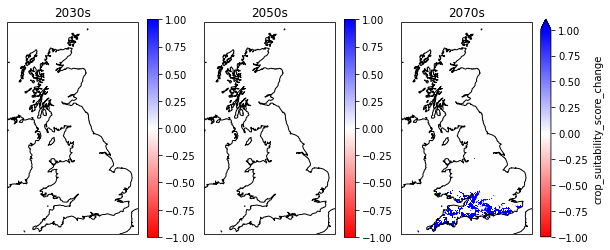

In [12]:
plot_decadal_changes(allscore_decadal_changes, cmax=1, cmin=-1)

In [ ]:
allscore_decadal_changes, tempscore_decadal_changes, precscore_decadal_changes = \
calc_decadal_changes(final_score_crop, tempscore, precscore, str(SOIL), lcmloc, bgsloc, cropname, savedir)
plot_decadal_changes(allscore_decadal_changes, save='plots/' + cropname + '_decadal_changes.png')
plot_decadal_changes(tempscore_decadal_changes, save='plots/' + cropname + '_tempscore_decadal_changes.png')
plot_decadal_changes(precscore_decadal_changes, save='plots/' + cropname + '_precscore_decadal_changes.png')

### Calculations v3

Trying with numba - not as fast now that I've solved the dask issue. Kept for reference.

In [2]:
ecocroploc = '/gws/nopw/j04/ceh_generic/matbro/ecocrop/EcoCrop_DB_secondtrim.csv'
taspath = '/gws/nopw/j04/ceh_generic/matbro/ecocrop/metdata/UKCP18_BC_01/tasmean/ukcp18_rcp85_land-rcm_uk_1km_01_v20190731_tas_bias_corrected_????.nc'
prepath = '/gws/nopw/j04/ceh_generic/matbro/ecocrop/metdata/UKCP18_BC_01/pr/ukcp18_rcp85_land-rcm_uk_1km_01_v20190731_pr_bias_corrected_????.nc'
tmxpath = '/gws/nopw/j04/ceh_generic/matbro/ecocrop/metdata/UKCP18_BC_01/tasmax/ukcp18_rcp85_land-rcm_uk_1km_01_v20190731_tasmax_bias_corrected_????.nc'
tmnpath = '/gws/nopw/j04/ceh_generic/matbro/ecocrop/metdata/UKCP18_BC_01/tasmin/ukcp18_rcp85_land-rcm_uk_1km_01_v20190731_tasmin_bias_corrected_????.nc'
tasvname = 'tas'
prevname = 'pr'
tmxvname = 'tasmax'
tmnvname = 'tasmin'
outdir = '/gws/nopw/j04/ceh_generic/matbro/ecocrop/outputs/'
year = '2020'

In [3]:
ecocropall = pd.read_csv(ecocroploc, engine='python')
ecocrop = ecocropall.drop(['level_0'], axis=1)
testcrop = ecocrop.iloc[19,:] # onions
TOPMIN = testcrop['TOPMN']
TOPMAX = testcrop['TOPMX']
PMIN = testcrop['RMIN']
PMAX = testcrop['RMAX']
POPMIN = testcrop['ROPMN']
POPMAX = testcrop['ROPMX']
KTMP = testcrop['KTMPR']
GMIN = testcrop['GMIN']
GMAX = testcrop['GMAX']
COMNAME = testcrop['COMNAME']
# assume killing temp of -1 if not specified
if np.isnan(KTMP):
    KTMP=-1

In [2]:
# Function that does a forward rolling sum without loops
# see https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-numpy-scipy
# can't be used with numba as it doesn't support cumsum on n-d arrays
def frs3D(indata, window):
    ret = np.cumsum(indata, axis=-1)
    ret[:,:,window:] = ret[:,:,window:] - ret[:,:,:-window]
    return ret[:,:,(window-1):]

In [4]:
@njit(parallel=True)
def csscore(tas, tmx, tmn, pre, gtime, TOPMIN, TOPMAX, KTMP, GMIN, GMAX, PMIN, PMAX):
    tdimlen = tas.shape[2]
    ydimlen = tas.shape[0]
    xdimlen = tas.shape[1]
    toptdays_crop = np.zeros((ydimlen, xdimlen, tdimlen-gtime+1), dtype=np.uint16)
    ktmp_days     = np.zeros((ydimlen, xdimlen, tdimlen-gtime+1), dtype=np.uint16)
    precip_crop   = np.zeros((ydimlen, xdimlen, tdimlen-gtime+1), dtype=np.uint16)

    # convert units from K-->C and kg/m^2/s-->mm/day
    print('Converting units')
    tas = tas - 273.15
    tmx = tmx - 273.15
    tmn = tmn - 273.15
    pre = pre*86400

    print('Doing calculations')
    print('First set of np.where calculations')
    # calculate days where temperature is within range of crop
    tmaxopt_crop = np.where(tas < TOPMAX, 0.5, 0)
    tminopt_crop = np.where(tas > TOPMIN, 0.5, 0)
    topt_crop = tmaxopt_crop + tminopt_crop
    topt_crop = np.where(topt_crop == 1, topt_crop, 0)

    # calculate days where temperature is below killing temperature of crop
    ktmp_crop = np.where(tmn < KTMP, 1, 0)

    # calculate where GMIN days of T in optimal range is satisfied with growing window of gtime
    #toptdays_crop = topt_crop[::-1,:,:].rolling(time=gtime).sum()[::-1,:,:]
    print('First rolling calc')
    #t=0
    #print(topt_crop[:,:,t:t+gtime].sum(axis=2).shape)
    #print(toptdays_crop[:,:,t].shape)
    for t in prange(0, tdimlen-gtime+1):
        toptdays_crop[:,:,t] = topt_crop[:,:,t:t+gtime].sum(axis=2)
    #toptdays_crop = frs3D(topt_crop, gtime)
    print('Second set of np.where calculations')
    suit_crop = np.where(toptdays_crop >= GMIN, 1, 0)
    print(suit_crop.shape)

    # calculate whether any of the suitable days/locations identified above will have
    # frost/killing temp in their growing window, and set suitability to 0 if so
    #ktmp_days = ktmp_crop[::-1,:,:].rolling(time=gtime).sum()[::-1,:,:]
    print('Second rolling calc')
    for t in prange(0, tdimlen-gtime+1):
        ktmp_days[:,:,t] = ktmp_crop[:,:,t:t+gtime].sum(axis=2)
    #ktmp_days = frs3D(ktmp_crop, gtime)
    print('Third set of np.where calculations')
    suit_crop2 = np.where(ktmp_days > 0, 0, suit_crop)

    # calculate total precipitation in the growing window and mask out any of the
    # suitable locations/days identified above if not within range for crop
    #precip_crop = pre[::-1,:,:].rolling(time=gtime).sum()[::-1,:,:]
    print('Third rolling calc')
    for t in prange(0, tdimlen-gtime+1):
        precip_crop[:,:,t] = pre[:,:,t:t+gtime].sum(axis=2)
    #precip_crop = frs3D(pre, gtime)
    print('Last set of np.where calculations')
    precip_suit = np.where(precip_crop > PMIN, suit_crop2, 0)
    precip_suit = np.where(precip_crop < PMAX, precip_suit, 0)
    precip_suit_total = np.where(precip_suit > 0, precip_crop, 0)

    # calculate the suitability scores for temp and precip
    tempscore = np.where(precip_suit > 0, score_temp(gtime, GMIN, GMAX), 0)
    precscore = score_prec(np.where(precip_suit_total>0, precip_suit_total, np.nan), PMIN, PMAX, POPMIN, POPMAX)

    # calculate final suitability score (take minimum of temp and precip scores)
    final_score_crop = np.where(precscore < tempscore, precscore, tempscore)
    
    return final_score_crop

In [5]:
%%time
comname = '_'.join(COMNAME.split(' '))
comname = ''.join(comname.split('('))
comname = ''.join(comname.split(')'))

if not os.path.exists(outdir):
    os.makedirs(outdir)

gtime = int(GMIN)+30
print('Calculating suitability for ' + comname + \
      ' for a growing season of length ' + str(gtime) + \
      ' out of a maximum of ' + str(int(GMAX)))

# open datafiles
nyer = str(int(year)+1)
print('Reading in met data')
tas1 = xr.load_dataset(year.join(taspath.split('????')))[tasvname]
tas2 = xr.load_dataset(nyer.join(taspath.split('????')))[tasvname]
pre1 = xr.load_dataset(year.join(prepath.split('????')))[prevname]
pre2 = xr.load_dataset(nyer.join(prepath.split('????')))[prevname]
tmx1 = xr.load_dataset(year.join(tmxpath.split('????')))[tmxvname]
tmx2 = xr.load_dataset(nyer.join(tmxpath.split('????')))[tmxvname]
tmn1 = xr.load_dataset(year.join(tmnpath.split('????')))[tmnvname]
tmn2 = xr.load_dataset(nyer.join(tmnpath.split('????')))[tmnvname]
tasx = xr.concat([tas1, tas2], dim='time')
prex = xr.concat([pre1, pre2], dim='time')
tmxx = xr.concat([tmx1, tmx2], dim='time')
tmnx = xr.concat([tmn1, tmn2], dim='time')
tdimlen = tasx.shape[0]
tcoords = tasx['time'][:tdimlen-gtime+1]
ycoords = tasx['y']
xcoords = tasx['x']

tas = tasx.values.transpose((1,2,0))
pre = prex.values.transpose((1,2,0))
tmx = tmxx.values.transpose((1,2,0))
tmn = tmnx.values.transpose((1,2,0))
print(tas.shape)

Calculating suitability for Onions_bulb for a growing season of length 115 out of a maximum of 175
Reading in met data
(1057, 656, 720)
CPU times: user 29.2 s, sys: 25.7 s, total: 54.9 s
Wall time: 4min 30s


In [6]:
start=dt.datetime.now()
final_score_crop = csscore(tas, tmx, tmn, pre, gtime, TOPMIN, TOPMAX, KTMP, GMIN, GMAX, PMIN, PMAX)
end=dt.datetime.now()
print(end-start)

final_score_crop_xr = xr.DataArray(final_score_crop, coords=[ycoords, xcoords, tcoords])
final_score_crop_xr.name = 'crop_suitability_score'
final_score_crop_xr.encoding['zlib'] = True
final_score_crop_xr.encoding['complevel'] = 1
final_score_crop_xr.encoding['shuffle'] = False
final_score_crop_xr.encoding['contiguous'] = False
final_score_crop_xr.encoding['dtype'] = np.dtype('uint16')
encoding = {}
encoding['crop_suitability_score'] = final_score_crop_xr.encoding
filepath = os.path.join(outdir, 'final_score_crop_'+comname+'_glen'+str(gtime)+'.nc')
final_score_crop_xr.to_netcdf(filepath, encoding=encoding)

<ipython-input-4-b720dcb81735>:64: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "ecocrop_utils.py", line 15:
@njit(parallel=True)
def score_temp(gtime, gmin, gmax):
^

  tempscore = np.where(precip_suit > 0, score_temp(gtime, GMIN, GMAX), 0)


Converting units
Doing calculations
First set of np.where calculations
First rolling calc
Second set of np.where calculations
(1057, 656, 606)
Second rolling calc
Third set of np.where calculations
Third rolling calc
Last set of np.where calculations
0:06:22.267979


/home/users/mattjbr/anaconda3/envs/ecocrop/lib/python3.9/site-packages/xarray/core/dataarray.py:2778: SerializationWarning: saving variable crop_suitability_score with floating point data as an integer dtype without any _FillValue to use for NaNs
  return dataset.to_netcdf(*args, **kwargs)


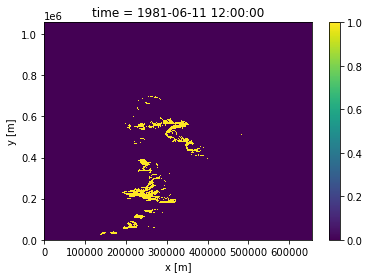

In [6]:
precip_suit[160,:,:].plot()

In [38]:
%matplotlib notebook

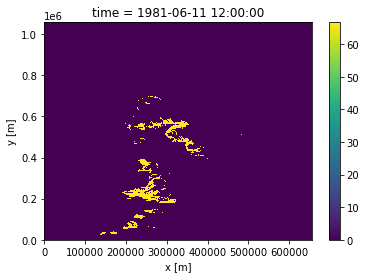

In [8]:
tempscore[160,:,:].plot()

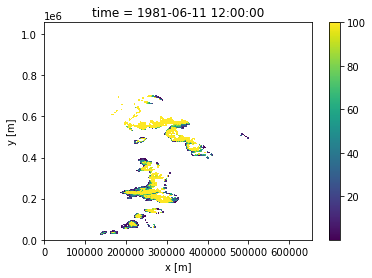

In [9]:
precscore[160,:,:].plot()

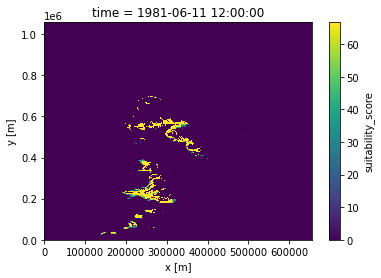

In [10]:
final_score_crop[160,:,:].plot()

Test plots when running for the entire 100year dataset at once

In [2]:
%matplotlib notebook

In [2]:
final_score_crop = xr.open_dataset('/gws/nopw/j04/ceh_generic/matbro/ecocrop/outputs/final_score_crop_Onions_bulb_glen115.nc').chunk({'time': 360})['suitability_score']

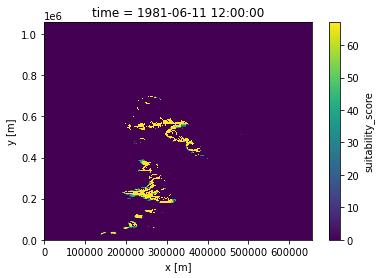

In [11]:
test = final_score_crop[160,:,:]
test = test.where(test<65535)
test.plot()

#### Float 32 vs Float 16 comparison for precip data

In [119]:
prepath = '/work/scratch-pw/mattjbr/ecocrop/metdata/ukcp18_rcp85_land-rcm_uk_1km_01_v20190731_pr_bias_corrected_' + str(year) + '.nc'
prevname = 'pr'
pre32 = xr.open_dataset(prepath)[prevname]
pre16 = xr.open_dataset(prepath).astype('float16')[prevname]

In [120]:
pre16.max()

<xarray.DataArray 'pr' ()>
array(0.003353, dtype=float16)

In [121]:
pre32.max()

<xarray.DataArray 'pr' ()>
array(0.00335353, dtype=float32)

In [122]:
pre16.where(pre16>0).min()

<xarray.DataArray 'pr' ()>
array(6.e-08, dtype=float16)

In [123]:
pre32.where(pre32>0).min()

<xarray.DataArray 'pr' ()>
array(2.4945117e-23, dtype=float32)

In [124]:
pre16.sum()

<xarray.DataArray 'pr' ()>
array(1533., dtype=float16)

In [125]:
pre32.sum()

<xarray.DataArray 'pr' ()>
array(2709.4082, dtype=float32)

#### Check disk read speeds

In [59]:
year=2021
prepath1 = '/work/scratch-pw/mattjbr/ecocrop/metdata/ukcp18_rcp85_land-rcm_uk_1km_01_v20190731_pr_bias_corrected_' + str(year) + '.nc'
prepath2 = '/home/users/mattjbr/ecocrop/metdata/UKCP18_BC_01/pr/ukcp18_rcp85_land-rcm_uk_1km_01_v20190731_pr_bias_corrected_' + str(year) + '.nc'
prepath3 = '/work/scratch-nopw/mattjbr/ecocrop/metdata/ukcp18_rcp85_land-rcm_uk_1km_01_v20190731_pr_bias_corrected_' + str(year) + '.nc'
prepath4 = '/work/scratch-pw2/mattjbr/ecocrop/metdata/ukcp18_rcp85_land-rcm_uk_1km_01_v20190731_pr_bias_corrected_' + str(year) + '.nc'
prevname = 'pr'

In [60]:
%%time
pre1 = xr.open_dataset(prepath1)[prevname]
presum1 = pre1.sum()
print(presum1)

<xarray.DataArray 'pr' ()>
array(3242.9622, dtype=float32)
CPU times: user 4.66 s, sys: 1.72 s, total: 6.38 s
Wall time: 10.5 s


In [61]:
%%time
pre2 = xr.open_dataset(prepath2)[prevname]
presum2 = pre2.sum()
print(presum2)

<xarray.DataArray 'pr' ()>
array(3242.9622, dtype=float32)
CPU times: user 4.68 s, sys: 897 ms, total: 5.57 s
Wall time: 26.8 s


In [62]:
%%time
pre3 = xr.open_dataset(prepath3)[prevname]
presum3 = pre3.sum()
print(presum3)

<xarray.DataArray 'pr' ()>
array(3242.9622, dtype=float32)
CPU times: user 4.52 s, sys: 868 ms, total: 5.39 s
Wall time: 6.76 s


In [ ]:
%%time
pre4 = xr.open_dataset(prepath4)[prevname]
presum4 = pre4.sum()
print(presum4)